In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from statistics import mean, median
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import shap

In [2]:
MR = 5

data_file = ("data/{}_mr_50_cond/simulated_noNoise.txt").format(MR)
grn_file = ("data/{}_mr_50_cond/bipartite_GRN.csv").format(MR)

data = pd.read_csv(data_file, sep="\t", header=0)
grn_df = pd.read_csv(grn_file, sep = ",", header = None, names=['TF_ID', 'G_ID'])
grn_df['class'] = 1

N_genes = 100  # total no. of genes
N_TFs = N_genes

In [19]:
n_estimators=1000  # number of trees in the forest (as per GENIE paper)
criterion='squared_error'  # variance reduction equivalent
random_state = 42  # for reproducibility
max_features = int(np.sqrt(N_TFs)) # max no. of features to use in each tree (as per GENIE paper)
subsample=0.9

In [20]:
# Normalize Expression data to unit-variance
data_n = StandardScaler(with_mean=False).fit_transform(data.to_numpy())

# Initialize matrices
W = np.zeros(shape=(N_genes,N_TFs))
W_shap = np.zeros(shape=(N_genes,N_TFs))
Fscores = np.zeros(shape=(N_genes,))

for j in np.arange(0,N_genes):
    # read TF and gene expression data X and Gj
    X, Gj= data_n[:,:N_TFs], data_n[:,N_genes+j]
    
    # fit an RF model to predict gene expression from TF
    M_rf_gb = GradientBoostingRegressor(criterion=criterion, n_estimators=n_estimators, loss='squared_error', subsample=subsample, max_features=max_features,  random_state=random_state).fit(X,Gj)
    # train score
    Fscores[j] = M_rf_gb.score(X,Gj)

    # Get the weights for all edges connecting TFs to gene j
    W[j,:] = M_rf_gb.feature_importances_

    # look at feature importance based on SHAP values
    explainer = shap.TreeExplainer(M_rf_gb)
    shap_values = explainer(X)
    W_shap[j,:] = np.mean(np.abs(shap_values.values), axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


auprc 0.10116743838117409
auroc 0.6544721989742268
mean auroc 0.6623154815527155
optimal threshold 0.00529621495691634


array([[6574, 2936],
       [ 218,  272]])

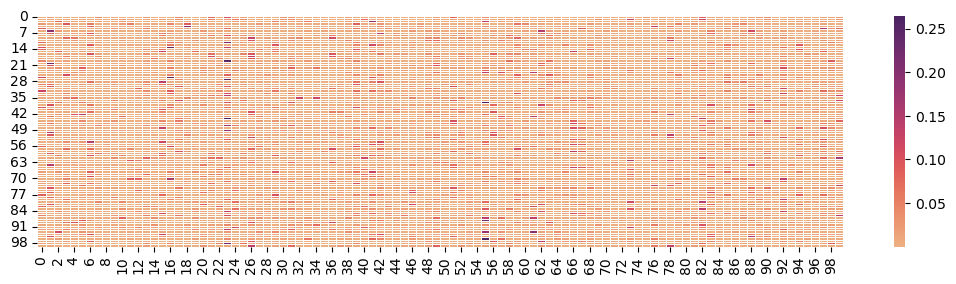

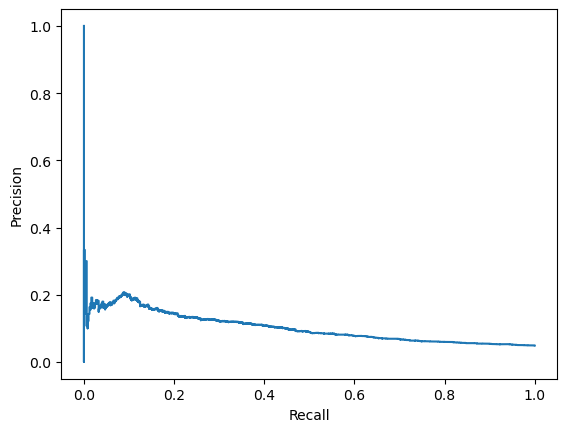

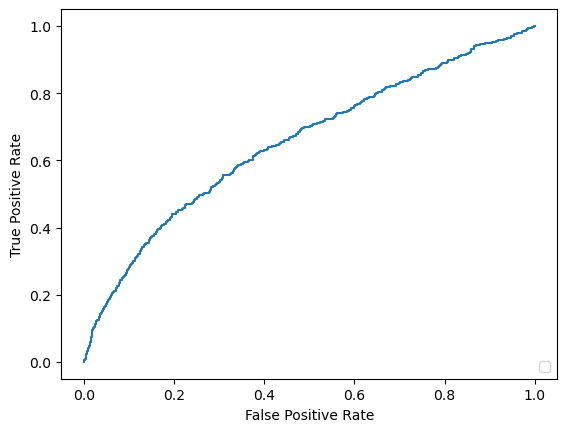

In [21]:
W_df = pd.DataFrame(np.abs(W))

plt.figure(figsize=(13, 3))
ax = sns.heatmap(W_df,
            cmap = "flare",
            linewidths=0.5)

grn_pred = pd.melt(W_df.reset_index(), id_vars = 'index', var_name='TF_ID', value_name='W_pred').rename(columns={'index': 'G_ID'})

grn_pred['G_ID'] = grn_pred['G_ID'].astype(np.int64) + 100
grn_pred['TF_ID'] = grn_pred['TF_ID'].astype(np.int64)

grn_eval = pd.merge(grn_pred,grn_df, on=['G_ID', 'TF_ID'], how='left')
grn_eval['class'] = grn_eval['class'].fillna(int(0))

grn_eval.to_csv("results/{}_mr_50_cond/grn_eval_rf.csv".format(MR))

precision, recall, thresholds_prc = precision_recall_curve(grn_eval['class'], grn_eval['W_pred'])
fpr, tpr, thresholds_roc = roc_curve(grn_eval['class'], grn_eval['W_pred'])
# Use AUC function to calculate the area under the curve of precision recall curve
print("auprc" , auc(recall, precision))
print("auroc" , auc(fpr,tpr))

roc_gene = [] 
for i in range(100):
    grn_eval_gene = grn_eval.iloc[i::N_TFs,:]
    roc_gene.append(metrics.roc_auc_score(grn_eval_gene['class'], grn_eval_gene['W_pred']))
    
print("mean auroc", mean(roc_gene))

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
print("optimal threshold", optimal_threshold)

grn_eval.loc[grn_eval['W_pred'] >= optimal_threshold, 'pred'] = 1
grn_eval.loc[grn_eval['W_pred'] < optimal_threshold, 'pred'] = 0

confusion_matrix(grn_eval['class'], grn_eval['pred'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


auprc 0.11804411738557063
auroc 0.6797193072812722
mean auroc 0.6623154815527155
optimal threshold 0.01254858019056468


array([[7848, 1662],
       [ 290,  200]])

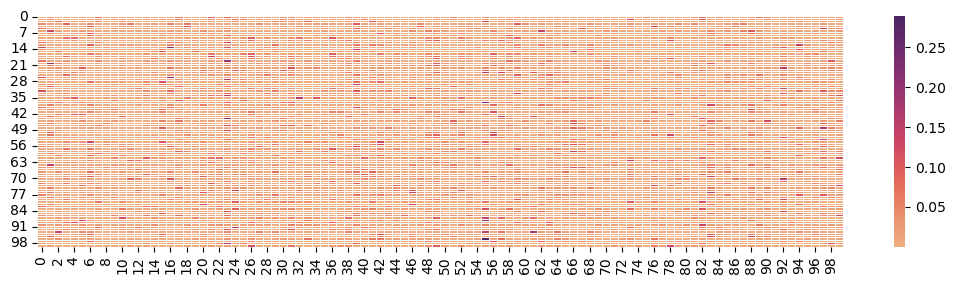

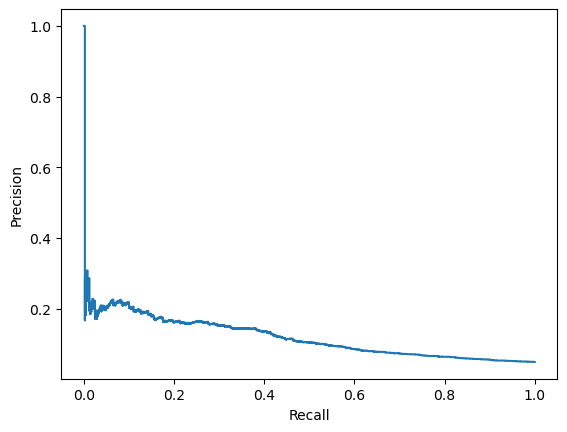

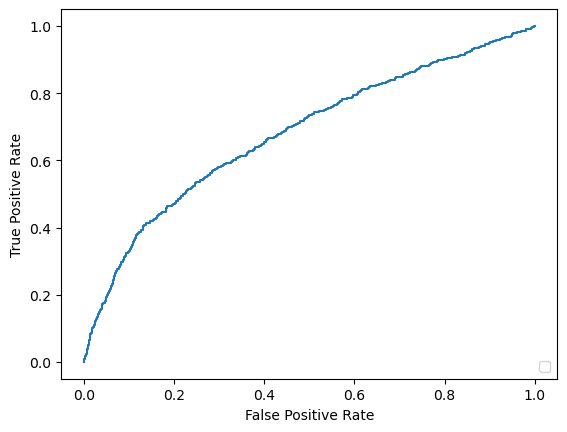

In [22]:
W_shap_df = pd.DataFrame(np.abs(W_shap))

plt.figure(figsize=(13, 3))
ax = sns.heatmap(W_shap_df,
            cmap = "flare",
            linewidths=0.5)

grn_pred_shap = pd.melt(W_shap_df.reset_index(), id_vars = 'index', var_name='TF_ID', value_name='W_pred').rename(columns={'index': 'G_ID'})

grn_pred_shap['G_ID'] = grn_pred_shap['G_ID'].astype(np.int64) + 100
grn_pred_shap['TF_ID'] = grn_pred_shap['TF_ID'].astype(np.int64)

grn_eval_shap = pd.merge(grn_pred_shap,grn_df, on=['G_ID', 'TF_ID'], how='left')
grn_eval_shap['class'] = grn_eval_shap['class'].fillna(int(0)) == 1.0

grn_eval.to_csv("results/{}_mr_50_cond/grn_eval_rf_shap.csv".format(MR))

precision, recall, thresholds_prc = precision_recall_curve(grn_eval_shap['class'], grn_eval_shap['W_pred'])
fpr, tpr, thresholds_roc = roc_curve(grn_eval_shap['class'], grn_eval_shap['W_pred'])
# Use AUC function to calculate the area under the curve of precision recall curve
print("auprc" , auc(recall, precision))
print("auroc" , auc(fpr,tpr))

roc_gene = [] 
for i in range(100):
    grn_eval_gene = grn_eval.iloc[i::N_TFs,:]
    roc_gene.append(metrics.roc_auc_score(grn_eval_gene['class'], grn_eval_gene['W_pred']))
    
print("mean auroc", mean(roc_gene))

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
print("optimal threshold", optimal_threshold)

grn_eval.loc[grn_eval['W_pred'] >= optimal_threshold, 'pred'] = 1
grn_eval.loc[grn_eval['W_pred'] < optimal_threshold, 'pred'] = 0

confusion_matrix(grn_eval['class'], grn_eval['pred'])